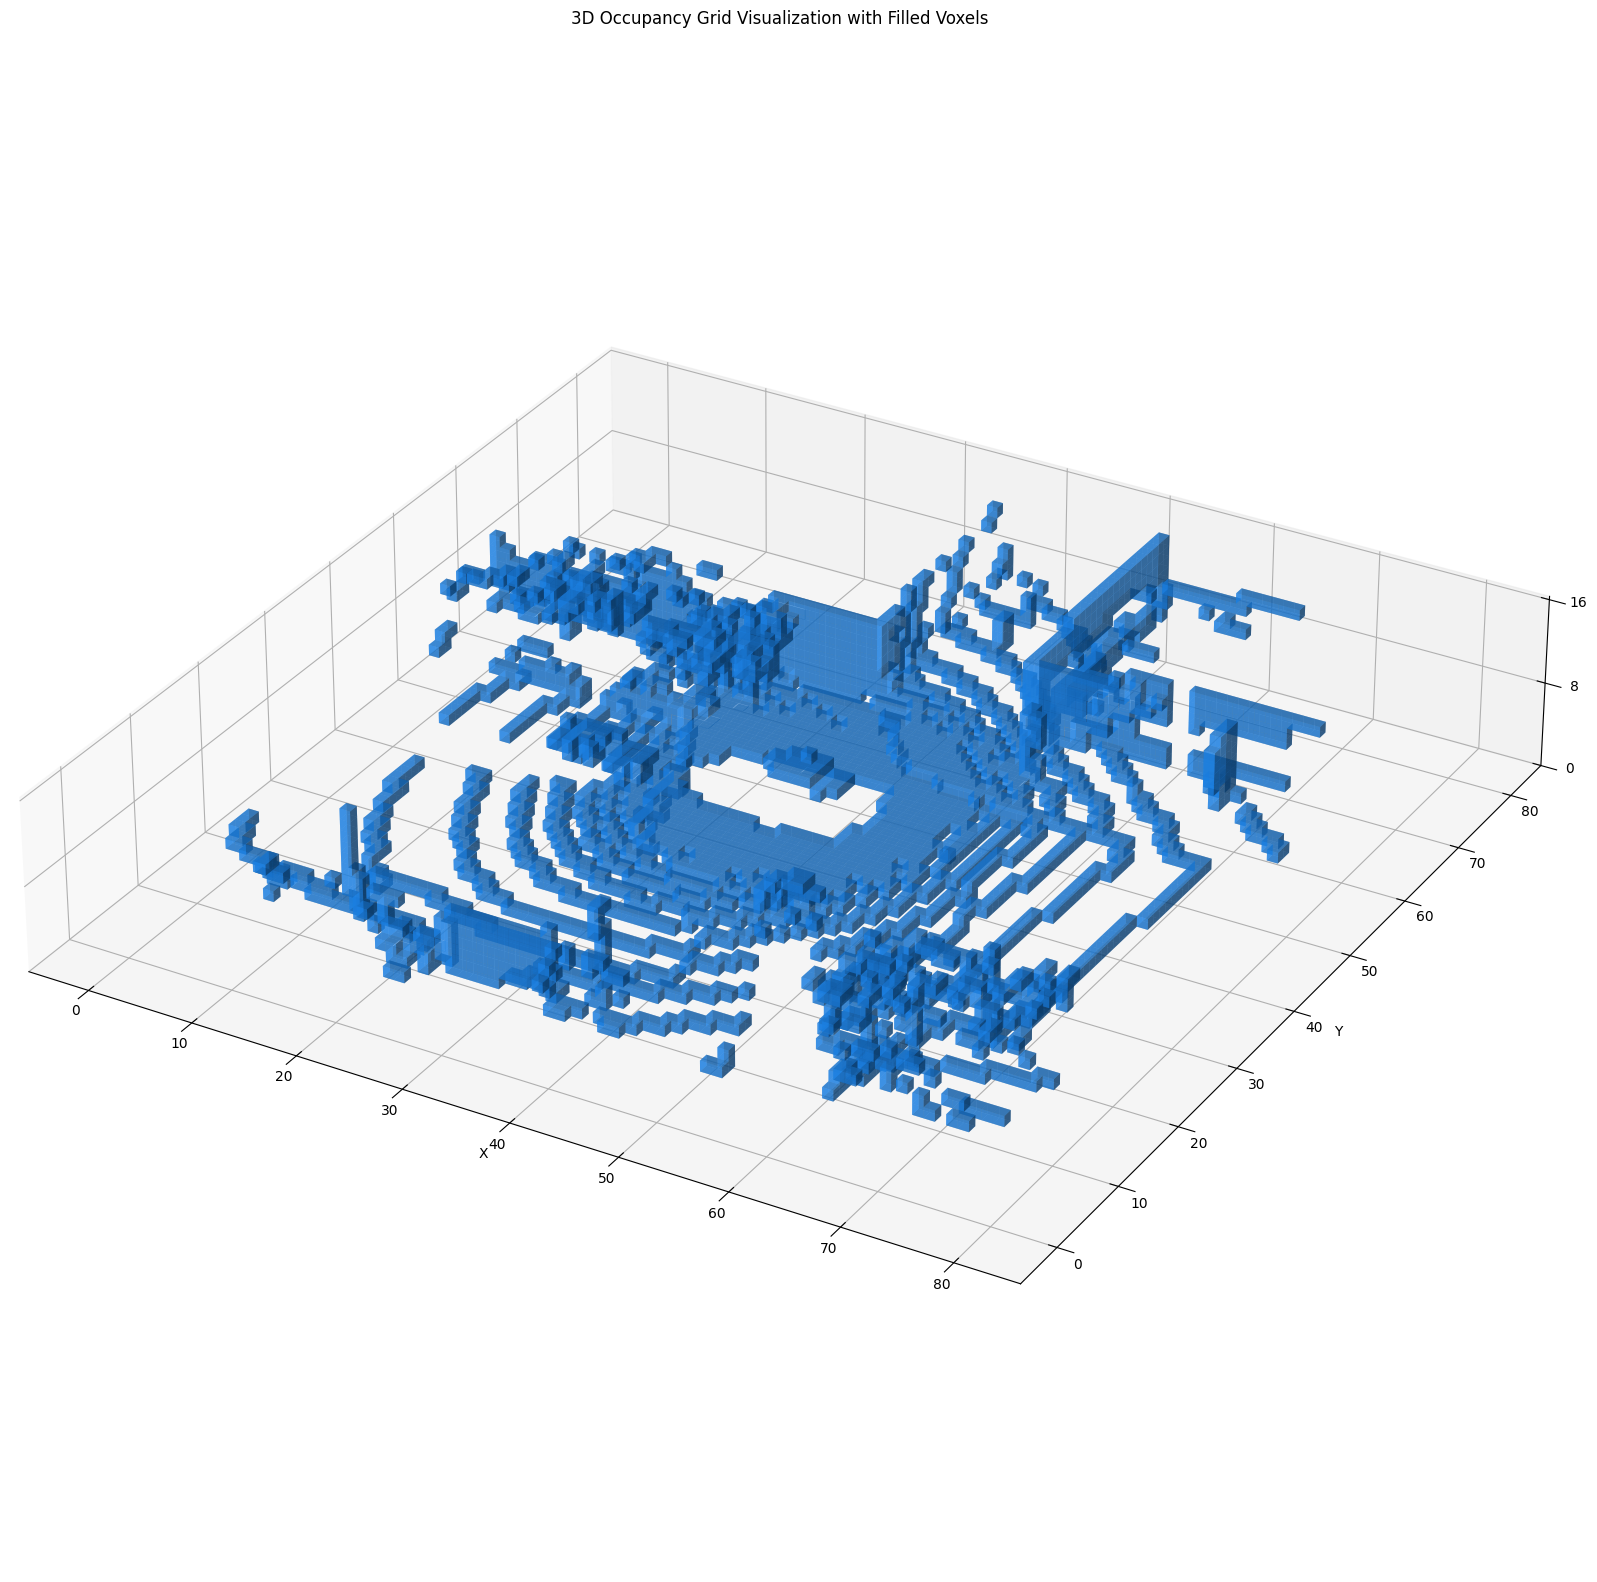

In [4]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import torch
import os
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Set default renderer
pio.renderers.default = 'browser'

class Voxelizer(torch.nn.Module):
    """Voxelizer for converting Lidar point cloud to image"""

    def __init__(self, x_min, x_max, y_min, y_max, step, z_min, z_max, z_step):
        super().__init__()

        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.step = step
        self.z_min = z_min
        self.z_max = z_max
        self.z_step = z_step

        self.width = round((self.x_max - self.x_min) / self.step)
        self.height = round((self.y_max - self.y_min) / self.step)
        self.z_depth = round((self.z_max - self.z_min) / self.z_step)
        self.depth = self.z_depth

    def voxelize_single(self, lidar, bev):
        indices_h = torch.floor((lidar[:, 1] - self.y_min) / self.step).long()
        indices_w = torch.floor((lidar[:, 0] - self.x_min) / self.step).long()
        indices_d = torch.floor((lidar[:, 2] - self.z_min) / self.z_step).long()

        valid_mask = ~torch.any(
            torch.stack(
                [
                    indices_h < 0,
                    indices_h >= self.height,
                    indices_w < 0,
                    indices_w >= self.width,
                    indices_d < 0,
                    indices_d >= self.z_depth,
                ]
            ),
            dim=0,
        )
        indices_h = indices_h[valid_mask]
        indices_w = indices_w[valid_mask]
        indices_d = indices_d[valid_mask]
        # 4. Assign indices to 1
        bev[indices_d, indices_h, indices_w] = 1.0

    def forward(self, lidars):
        batch_size = len(lidars)
        assert batch_size > 0 and len(lidars[0]) > 0
        num_sweep = len(lidars[0])

        bev = torch.zeros(
            (batch_size, num_sweep, self.depth, self.height, self.width),
            dtype=torch.float,
            device=lidars[0][0][0].device,
        )

        for b in range(batch_size):
            assert len(lidars[b]) == num_sweep
            for i in range(num_sweep):
                self.voxelize_single(lidars[b][i], bev[b][i])
        return bev.view(batch_size, num_sweep * self.depth, self.height, self.width)[0]

if __name__ == "__main__":
    vox = Voxelizer(-20., 20., -20., 20., 0.5, -5., 3., 0.5)

    fn = "/mnt/data/Public_datasets/nuScenes/samples/LIDAR_TOP/n008-2018-08-30-10-33-52-0400__LIDAR_TOP__1535639756450885.pcd.bin"
    p = np.fromfile(fn, dtype=np.float32)
    p = p.reshape((-1, 5))

    xyz = p[:, :3]
    xyz = xyz[np.where((xyz[:,0] >= -20.) & (xyz[:,0] <= 20.))[0],:]
    xyz = xyz[np.where((xyz[:,1] >= -20.) & (xyz[:,1] <= 20.))[0],:]
    xyz = xyz[np.where((xyz[:,2] >= -5.) & (xyz[:,2] <= 3.))[0],:]
    voxels = vox([[torch.from_numpy(xyz)]])

    voxel_grid = voxels.numpy()
    voxel_grid = voxel_grid.astype(bool)
    voxel_grid = np.transpose(voxel_grid, (1,2,0))


    # Get the coordinates of non-zero voxels (value = 1)
    #voxels = np.argwhere(voxel_grid == 1)

    # Plotting with voxels
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    # Using `matplotlib`'s voxels feature for full cubes
    ax.voxels(voxel_grid, facecolors='dodgerblue', edgecolor='dodgerblue', linewidth=0.01, alpha=0.6)

    # Labeling the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zticks([0, 8, 16])
    ax.set_aspect('equal', 'box')
    ax.set_zlabel('Z')

    plt.title('3D Occupancy Grid Visualization with Filled Voxels')
    plt.show()